# Analyse de la qualité de l'air à Grenoble

Ce document présente une tentative d'analyse de l'évolution de la qualité de l'air à Grenoble suite au confinement du 17 mars 2020.

Les analyses ci-dessous ont été réalisées avec le langage de programmation R et les bibliothèques suivantes :

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(patchwork)
library(lubridate)
library(zoo)
library(patchwork)
library(broom)
library(repr)
options(repr.plot.width=16, repr.plot.height=8)
R.version.string


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



[1] "R version 3.5.2 (2018-12-20)"

## Récupération et nettoyage des données

Toutes les données ont été récupérées sur le site d'[Atmo](https://www.atmo-auvergnerhonealpes.fr/donnees/telecharger) en remplissant le formulaire. Les différents fichiers ainsi téléchargés se trouvent dans le dossier [data](data).

Le format de données est particulièrement pénible, une colonne par date. On va d'abord restructurer ça pour avoir une observation par ligne. On convertit également les colonnes `Date` et `Valeur` dans les types adéquats.

In [2]:
filenames = c(
    'data/2012_hourly.csv',
    'data/2013_hourly.csv',
    'data/2014_hourly.csv',
    'data/2015_hourly.csv',
    'data/2016_hourly.csv',
    'data/2017_hourly.csv',
    'data/2018_hourly.csv',
    'data/2019_hourly.csv',
    'data/2020_hourly.csv'
)
df = data.frame()
for(file in filenames) {
    new_df = read.csv(file, sep=';') %>%
        mutate_all(as.character) %>%
        pivot_longer(c(-Station, -Polluant, -Mesure, -Unité), names_to="raw_date", values_to="Valeur", names_prefix="X") %>%
        mutate(Date=parse_date_time(raw_date, "dmyhM"), Valeur=as.numeric(sub(",", ".", Valeur)))
    df = rbind(df, new_df)
}
str(df)
head(df)

Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 17 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 18 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 18 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 17 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“NAs introduits lors de la conversion automatique”

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1134434 obs. of  7 variables:
 $ Station : chr  "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" ...
 $ Polluant: chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Mesure  : chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Unité   : chr  "microg/m3" "microg/m3" "microg/m3" "microg/m3" ...
 $ raw_date: chr  "01.01.2012.0.00" "01.01.2012.1.00" "01.01.2012.2.00" "01.01.2012.3.00" ...
 $ Valeur  : num  NA NA 37 46 55 57 40 28 20 33 ...
 $ Date    : POSIXct, format: "2012-01-01 00:00:00" "2012-01-01 01:00:00" ...


Station,Polluant,Mesure,Unité,raw_date,Valeur,Date
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2012.0.00,NA,2012-01-01 00:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2012.1.00,NA,2012-01-01 01:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2012.2.00,37,2012-01-01 02:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2012.3.00,46,2012-01-01 03:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2012.4.00,55,2012-01-01 04:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2012.5.00,57,2012-01-01 05:00:00


In [3]:
df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,260740
Dioxyde de soufre,73952
Monoxyde d'azote,260740
Ozone,112836
Particules PM10,260740
"Particules PM2,5",17522
Particules PM2.5,147904


On voit qu'il y a deux intitulés différents pour les PM 2.5, l'un avec une virgule, l'autre avec un point. On renomme celui avec la virgule.

In [4]:
df = df %>% mutate(Mesure=ifelse(grepl("Particules PM2", Mesure), "Particules PM2.5", Mesure))
df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,260740
Dioxyde de soufre,73952
Monoxyde d'azote,260740
Ozone,112836
Particules PM10,260740
Particules PM2.5,165426


Un certain nombre de valeurs sont manquantes. On commence par regarder si elles ont une distribution particulière.

In [5]:
df %>% filter(is.na(Date)) %>% select(raw_date, Date) %>% unique()

raw_date,Date
<chr>,<dttm>
28.10.2012.2.00.1,NA
27.10.2013.2.00.1,NA
26.10.2014.2.00.1,NA
25.10.2015.2.00.1,NA
30.10.2016.2.00.1,NA
29.10.2017.2.00.1,NA
28.10.2018.2.00.1,NA
27.10.2019.2.00.1,NA


In [6]:
df %>% filter(grepl("29.10.2017.2.00|28.10.2018.2.00|27.10.2019.2.00", raw_date)) %>% select(raw_date, Date) %>% unique()

raw_date,Date
<chr>,<dttm>
29.10.2017.2.00,2017-10-29 02:00:00
29.10.2017.2.00.1,NA
28.10.2018.2.00,2018-10-28 02:00:00
28.10.2018.2.00.1,NA
27.10.2019.2.00,2019-10-27 02:00:00
27.10.2019.2.00.1,NA


Il y a deux entrées pour une même date les 29 octobre 2017, 28 octobre 2018 et 27 octobre 2019, à 02:00 du matin. Il s'agit des dates de passage à l'heure d'hiver, on va simplement supprimer les doublons.

In [7]:
df = df %>% filter(!is.na(Date))

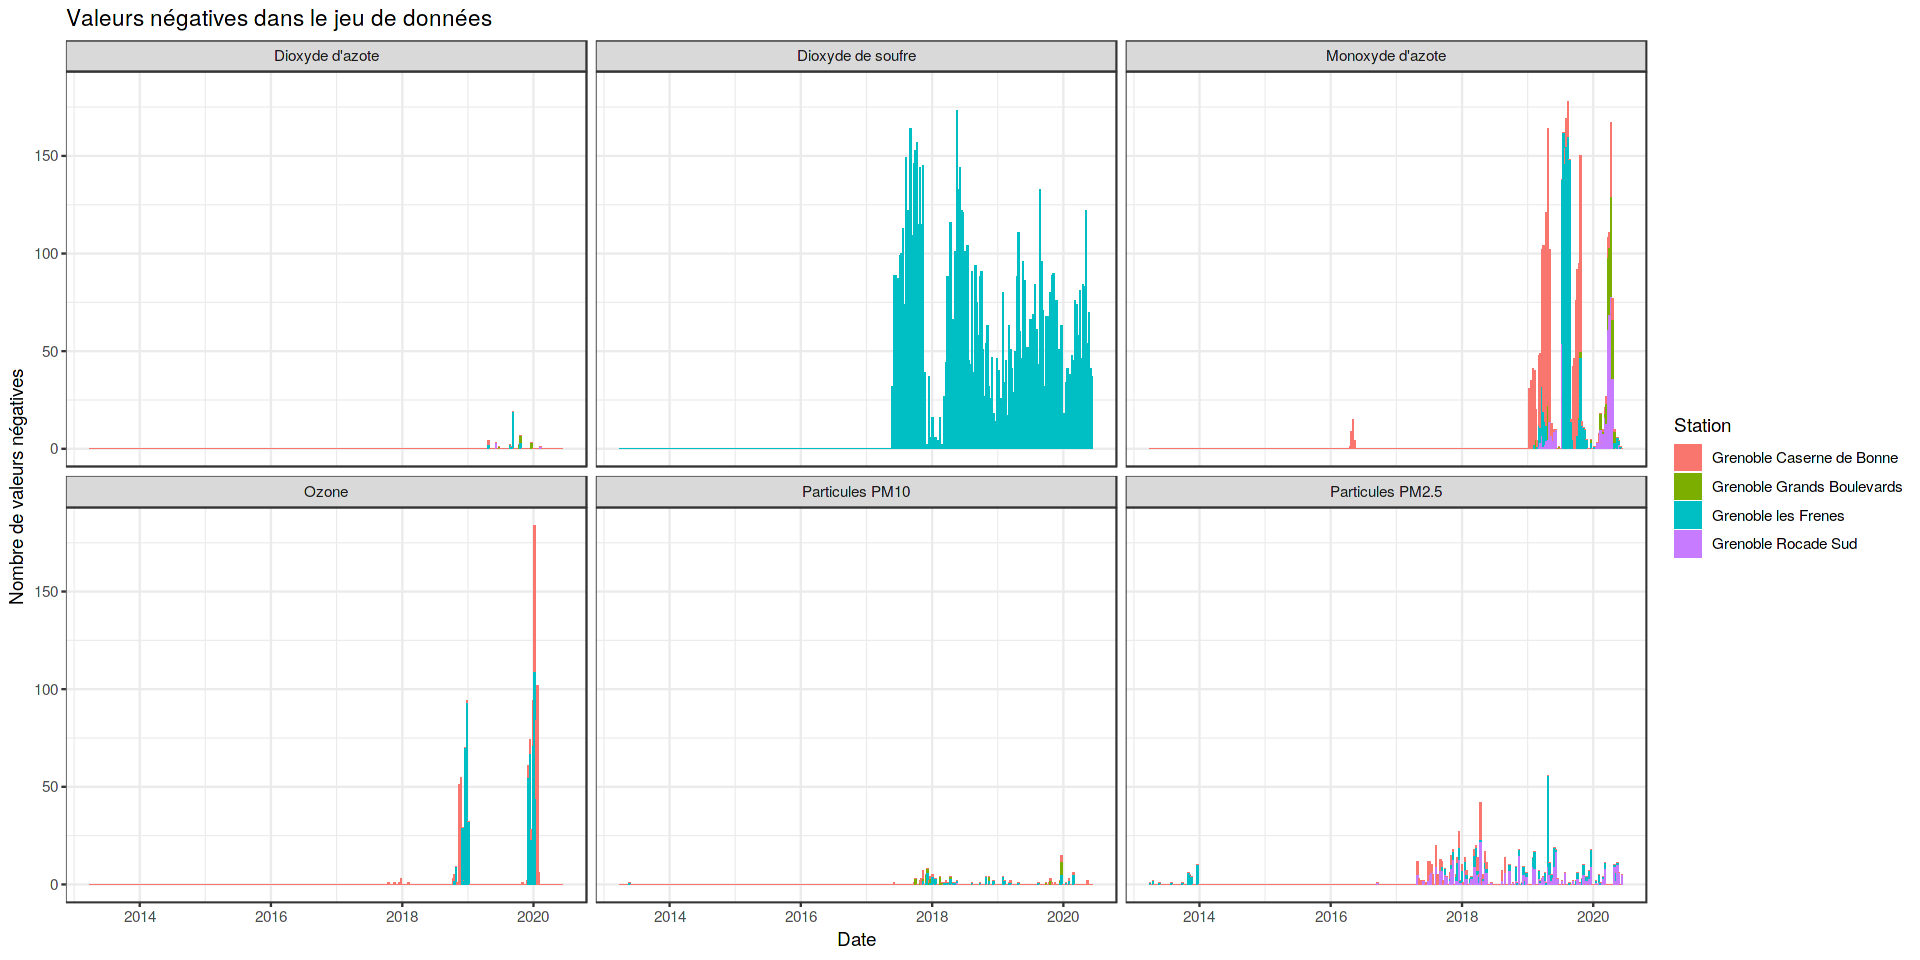

In [8]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(Valeur < 0) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs négatives") +
    ggtitle("Valeurs négatives dans le jeu de données")

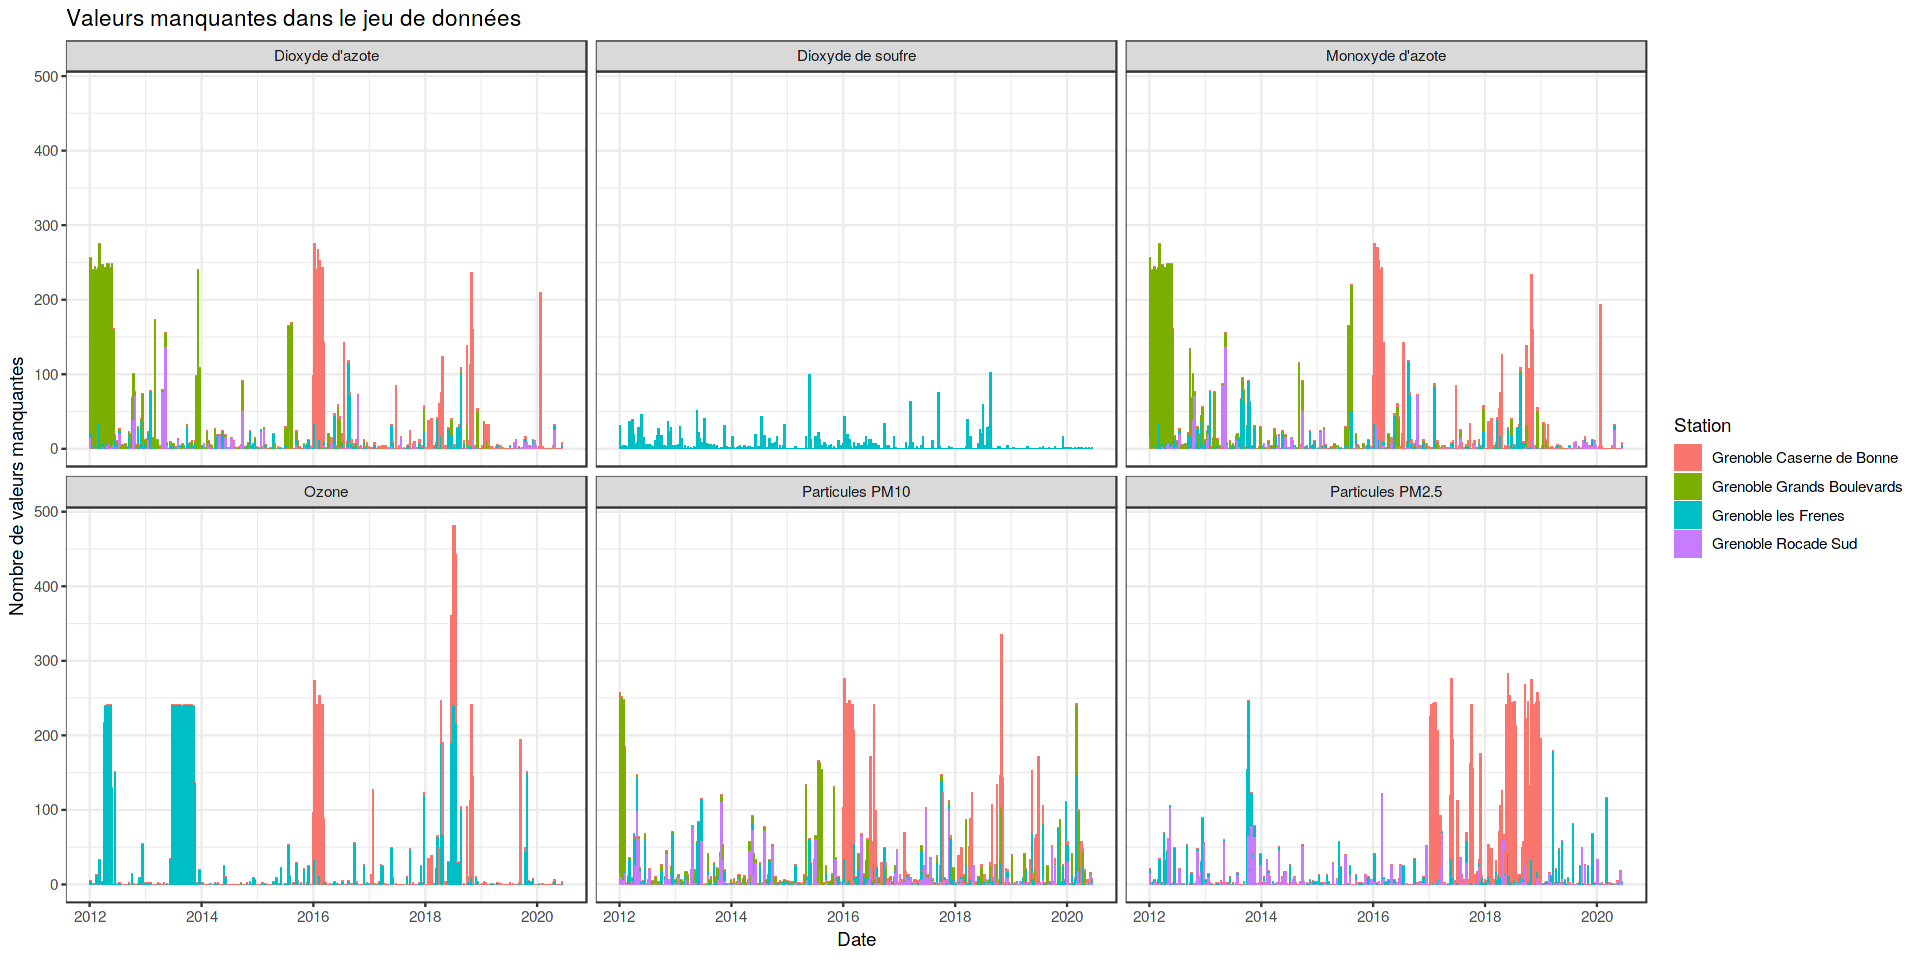

In [9]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(is.na(Valeur)) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs manquantes") +
    ggtitle("Valeurs manquantes dans le jeu de données")

On peut constater des manques de données sur certaines periodes, pour certaines stations. Cela correspond probablement à des pannes des capteurs. Ça sera à garder en tête par la suite dans les interprétations des courbes. On supprime les entrées avec des données manquantes.

In [10]:
df = df %>% drop_na()

Une première courbe d'évolution, pour visualiser les patterns temporels.

## Prédiction

On utilise la bibliothèque [Prophet](https://facebook.github.io/prophet/), développée par Facebook pour faire des prédictions sur des séries temporelles comme la notre.

In [11]:
library(prophet)

Loading required package: Rcpp
Loading required package: rlang


In [12]:
tmp = df %>%
    filter(Station == "Grenoble les Frenes", Mesure == "Particules PM2.5") %>%
    mutate(Day=parse_date_time(format(Date, format="%Y/%m/%d"), "Ymd")) %>%
    group_by(Day) %>%
    summarise(y=mean(Valeur)) %>%
    ungroup() %>%
    mutate(ds=Day) %>%
    select(ds, y)
tmp %>% head()

ds,y
<dttm>,<dbl>
2012-01-01,30.090909
2012-01-02,22.291667
2012-01-03,11.545455
2012-01-04,17.208333
2012-01-05,17.333333
2012-01-06,7.708333


In [13]:
m = prophet(tmp)
future <- make_future_dataframe(m, periods = 2*365)
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


,ds,yhat,yhat_lower,yhat_upper
,<dttm>,<dbl>,<dbl>,<dbl>
3767,2022-06-02,3.447708,-7.140079,14.15090
3768,2022-06-03,3.392968,-6.575631,14.26683
3769,2022-06-04,3.147371,-6.498431,13.59540
3770,2022-06-05,2.828491,-7.824104,13.29869
3771,2022-06-06,2.716771,-7.012995,13.46918
3772,2022-06-07,3.301906,-7.294679,13.74451


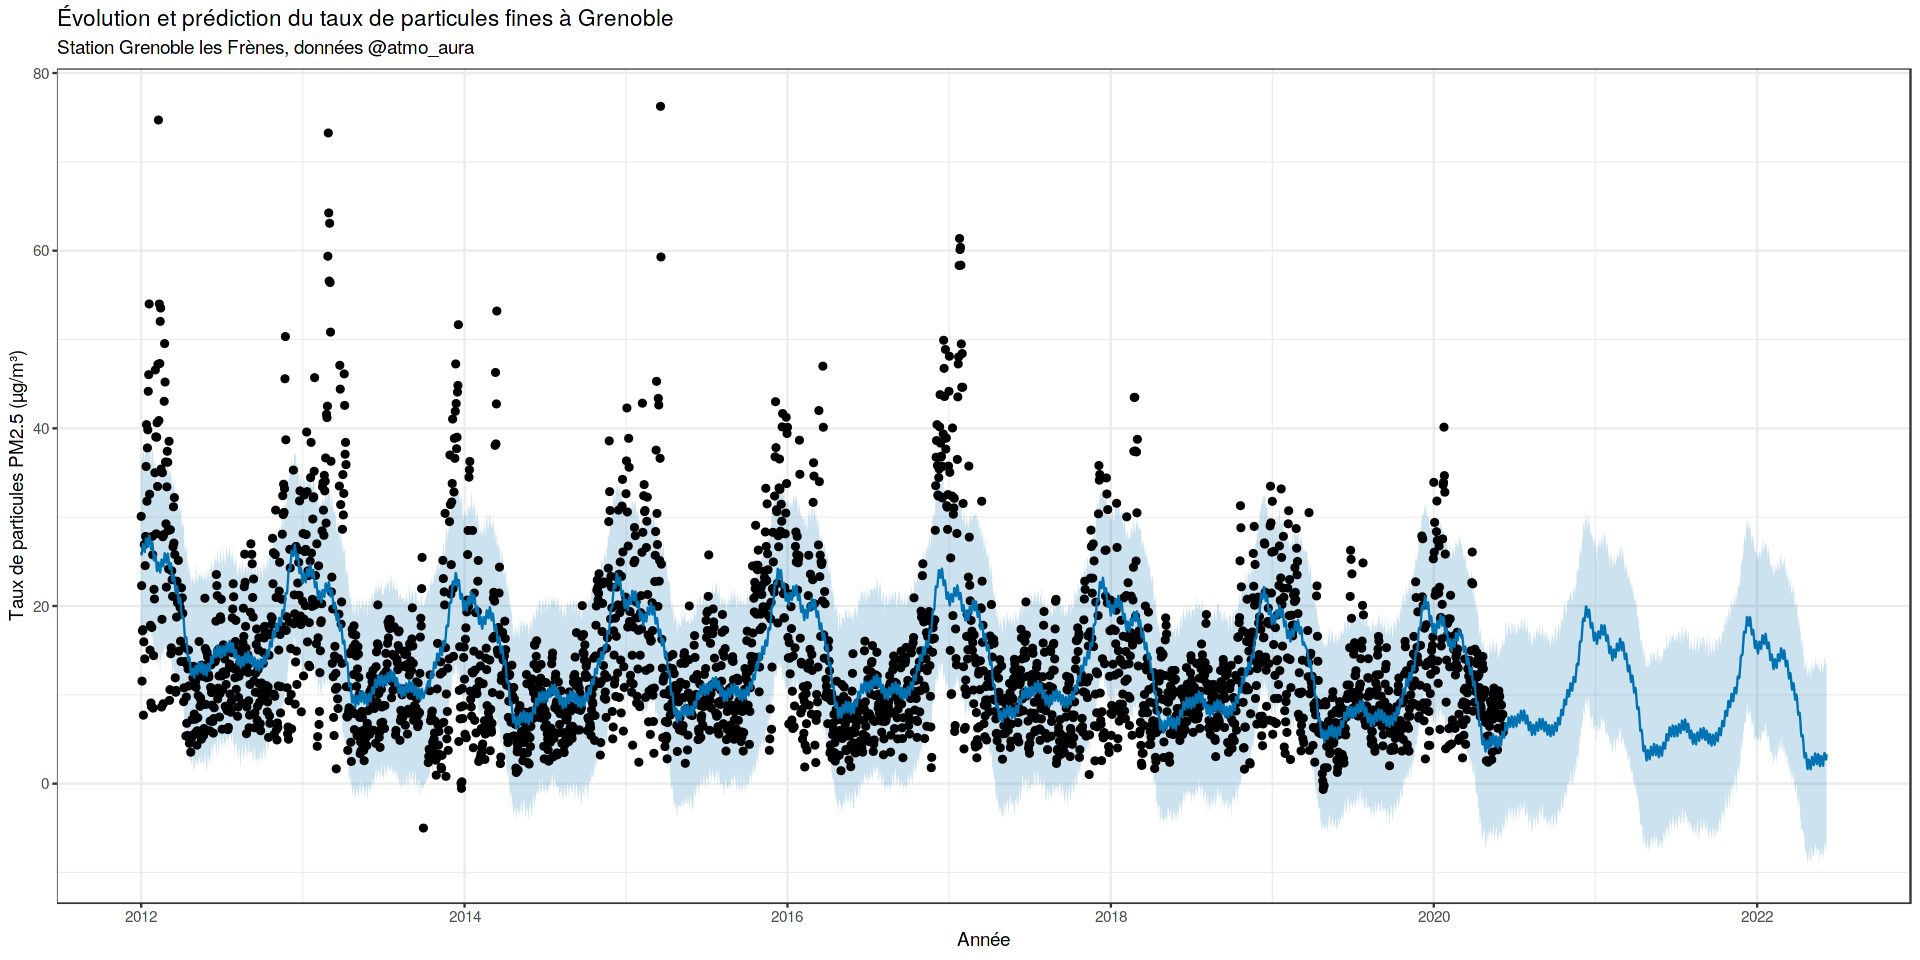

In [14]:
plot(m, forecast) +
    theme_bw() +
    xlab("Année") +
    ylab("Taux de particules PM2.5 (µg/m³)") +
    ggtitle("Évolution et prédiction du taux de particules fines à Grenoble",
           subtitle="Station Grenoble les Frènes, données @atmo_aura")

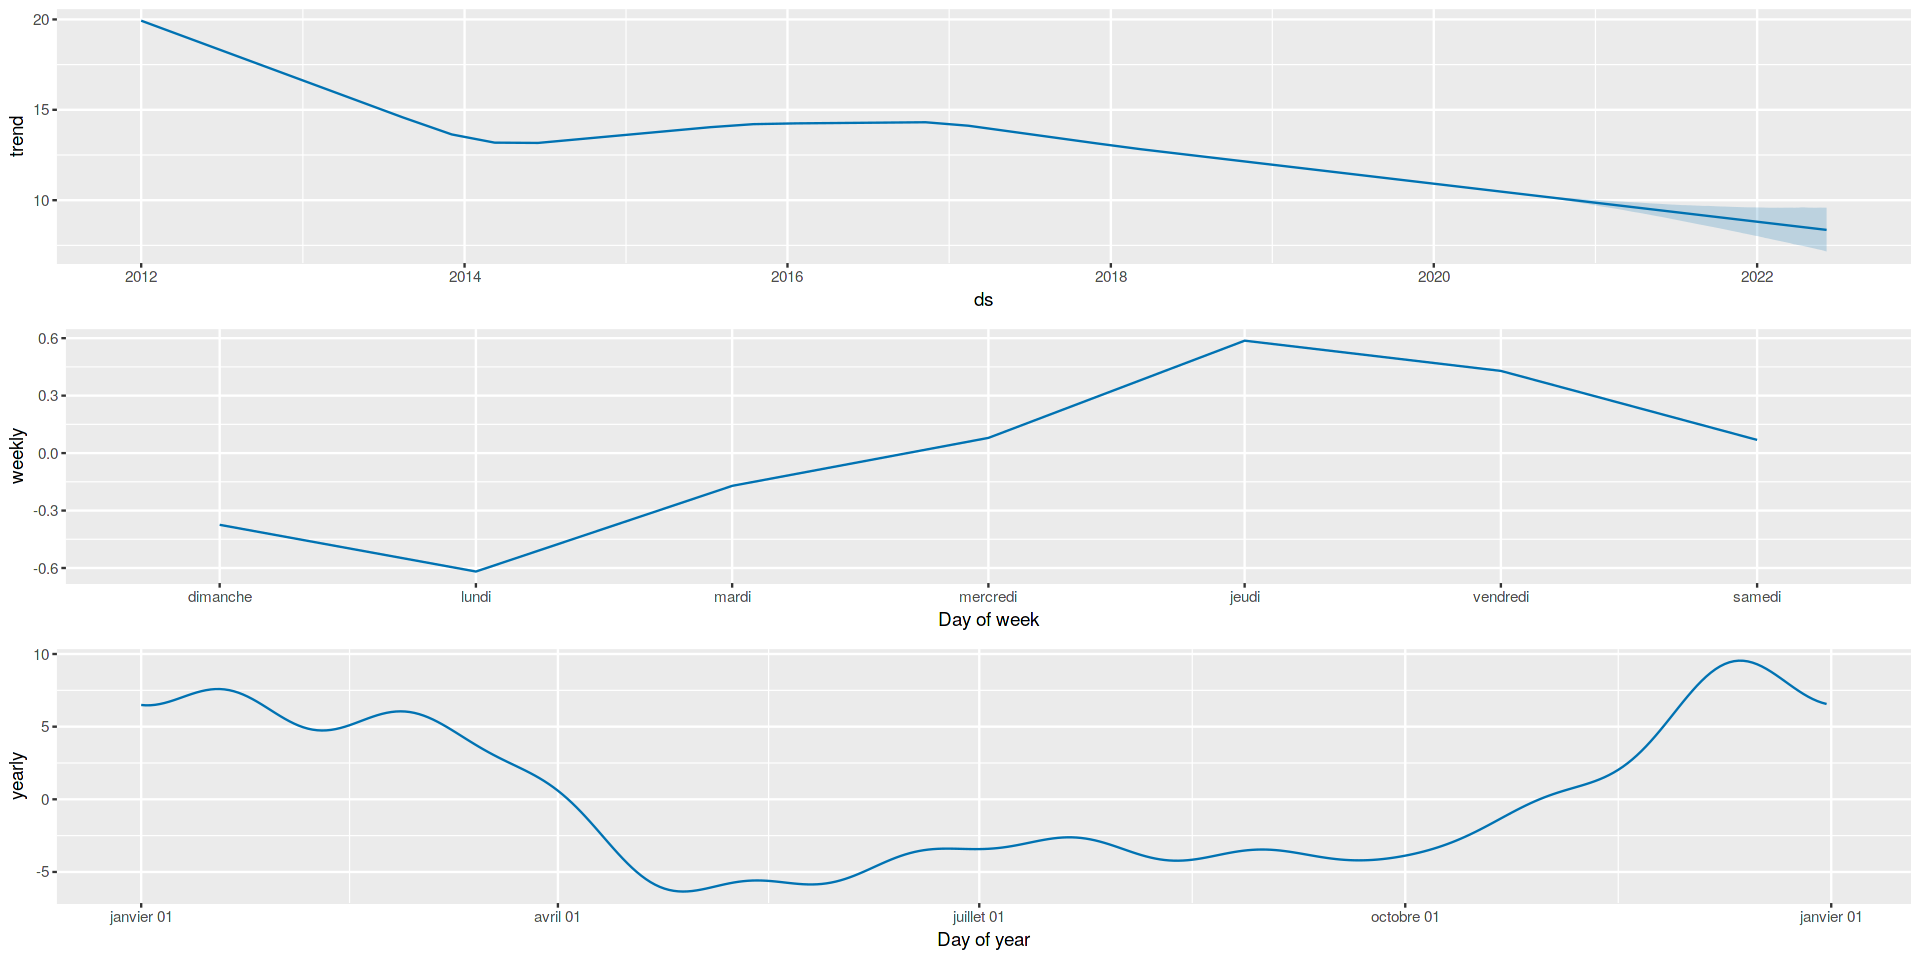

In [15]:
prophet_plot_components(m, forecast)